In this notebook, we want to:

- investigate the spatial structure of the residual stream
- see which tokens the different directions in the residual stream map to

# setup


In [52]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing
from collections import Counter

# Numerical Computing
import numpy as np
import torch
import pandas as pd
# import torch.nn.functional as F
from fancy_einsum import einsum
import einops
from jaxtyping import Float, Int, Bool

# scipy
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
# from scipy.spatial.distance import cosine

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets


# muutils
from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook
# TransformerLens imports
from transformer_lens import HookedTransformer, ActivationCache

# Our Code
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP
from maze_dataset.tokenization.token_utils import strings_to_coords, coords_to_strings
from maze_dataset.constants import _SPECIAL_TOKENS_ABBREVIATIONS

from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig
from maze_transformer.utils.dict_shapes import string_dict_shapes
from maze_transformer.mechinterp.plot_weights import plot_embeddings
from maze_transformer.mechinterp.residual_stream_structure import (
    TokenPlottingInfo, process_tokens_for_pca, EmbeddingsPCAResult, compute_pca, plot_pca_colored, 
    compute_distances_and_correlation, compute_grid_distances,
    plot_distances_matrix, plot_distance_grid, plot_correlation,
)


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)


DEVICE = device(type='cpu')


In [3]:
# path to load the model from
MODEL_PATH: str = "../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj"
# load the model and tokenizer
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
num_params: int = MODEL.num_params()
print(f"loaded model with {shorten_numerical_to_str(num_params)} params ({num_params = }) from\n{MODEL_PATH}")
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer

self.tokenization_mode = <TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>
self.tokenization_mode = <TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>
loaded model with 1.3M params (num_params = 1274699) from
../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj


In [4]:
# get tokenizer and embedding info
print(f"{TOKENIZER.token_arr = }")
d_model: int = MODEL.config.d_model
print(f"{MODEL.W_E.shape = }")
assert MODEL.W_E.shape == (TOKENIZER.vocab_size, d_model)
VOCAB_TOKENS: Int[torch.Tensor, "vocab_size"] = torch.arange(TOKENIZER.vocab_size, device=DEVICE)
assert VOCAB_TOKENS.tolist() == TOKENIZER.encode(TOKENIZER.token_arr)

# maps token to (index, coordinate)
COORDINATE_TOKENS_INFO: dict[str, (int, tuple[int,int])] = {
    tok: coord
    for idx, (tok, coord) in enumerate(zip(TOKENIZER.token_arr, TOKENIZER.strings_to_coords(TOKENIZER.token_arr, when_noncoord="include")))
    if not isinstance(coord, str)
}
print(f"{COORDINATE_TOKENS_INFO = }")

# information for how to plot the tokens
VOCAB_PLOT_INFO: list[TokenPlottingInfo] = process_tokens_for_pca(TOKENIZER)

TOKENIZER.token_arr = ['<ADJLIST_START>', '<ADJLIST_END>', '<TARGET_START>', '<TARGET_END>', '<ORIGIN_START>', '<ORIGIN_END>', '<PATH_START>', '<PATH_END>', '<-->', ';', '<PADDING>', '(0,0)', '(0,1)', '(1,0)', '(1,1)', '(0,2)', '(2,0)', '(1,2)', '(2,1)', '(2,2)', '(0,3)', '(3,0)', '(3,1)', '(2,3)', '(3,2)', '(1,3)', '(3,3)', '(0,4)', '(2,4)', '(4,0)', '(1,4)', '(4,1)', '(4,2)', '(3,4)', '(4,3)', '(4,4)', '(0,5)', '(5,0)', '(5,1)', '(2,5)', '(5,2)', '(5,3)', '(4,5)', '(5,4)', '(1,5)', '(3,5)', '(5,5)', '(0,6)', '(2,6)', '(4,6)', '(6,0)', '(1,6)', '(6,1)', '(6,2)', '(3,6)', '(6,3)', '(6,4)', '(5,6)', '(6,5)', '(6,6)', '(0,7)', '(7,0)', '(7,1)', '(2,7)', '(7,2)', '(7,3)', '(4,7)', '(7,4)', '(7,5)', '(6,7)', '(7,6)', '(1,7)', '(3,7)', '(5,7)', '(7,7)']
MODEL.W_E.shape = torch.Size([75, 128])
COORDINATE_TOKENS_INFO = {'(0,0)': (0, 0), '(0,1)': (0, 1), '(1,0)': (1, 0), '(1,1)': (1, 1), '(0,2)': (0, 2), '(2,0)': (2, 0), '(1,2)': (1, 2), '(2,1)': (2, 1), '(2,2)': (2, 2), '(0,3)': (0, 3), '(3,0

# PCA of token embeddings

In [5]:
# compute the PCA
PCA_RESULTS: dict[str, EmbeddingsPCAResult] = compute_pca(
    model=MODEL,
    token_plotting_info=VOCAB_PLOT_INFO,
)

In [6]:
ipywidgets.interact(
    plot_pca_colored, 
    pca_results_options=ipywidgets.fixed(PCA_RESULTS),
    pca_results_key=ipywidgets.Dropdown(
        options=list(PCA_RESULTS.keys()),
        value='all',
        description='PCA Results:',
    ),
    vocab_colors=ipywidgets.fixed(VOCAB_PLOT_INFO), 
    dim1=ipywidgets.IntText(
        value=1,
        description='Dim 1:',
    ),
    dim2=ipywidgets.IntText(
        value=2,
        description='Dim 1:',
    ),
    lattice_connections=ipywidgets.Dropdown(
        options=[True, False],
        value=True,
        description='Show Lattice:',
    ),
    # float or None (entry box of float or text)
    symlog_scale=ipywidgets.FloatText(
        value=-1,
        description='Symlog Scale:',
    ),
    axes_and_centered=ipywidgets.Dropdown(
        options=[True, False],
        value=True,
        description='Center and show axes:',
    ),
);

interactive(children=(Dropdown(description='PCA Results:', options=('all', 'coords_only', 'special_only'), val…

In [49]:
# possible distance functions:
"""
'braycurtis', 'canberra', 'chebyshev', 'cityblock',
'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
'jaccard', 'jensenshannon', 'kulczynski1',
'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto',
'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath',
'sqeuclidean', 'yule'
"""

MODEL_EMBEDDING_MATRIX: Float[np.ndarray, "d_vocab d_model"] = MODEL.W_E.detach().cpu().numpy()

distances_result: dict = compute_distances_and_correlation(
    embedding_matrix=MODEL_EMBEDDING_MATRIX,
    tokenizer=TOKENIZER,
    embedding_metric="cosine",
    coordinate_metric="cityblock",
)

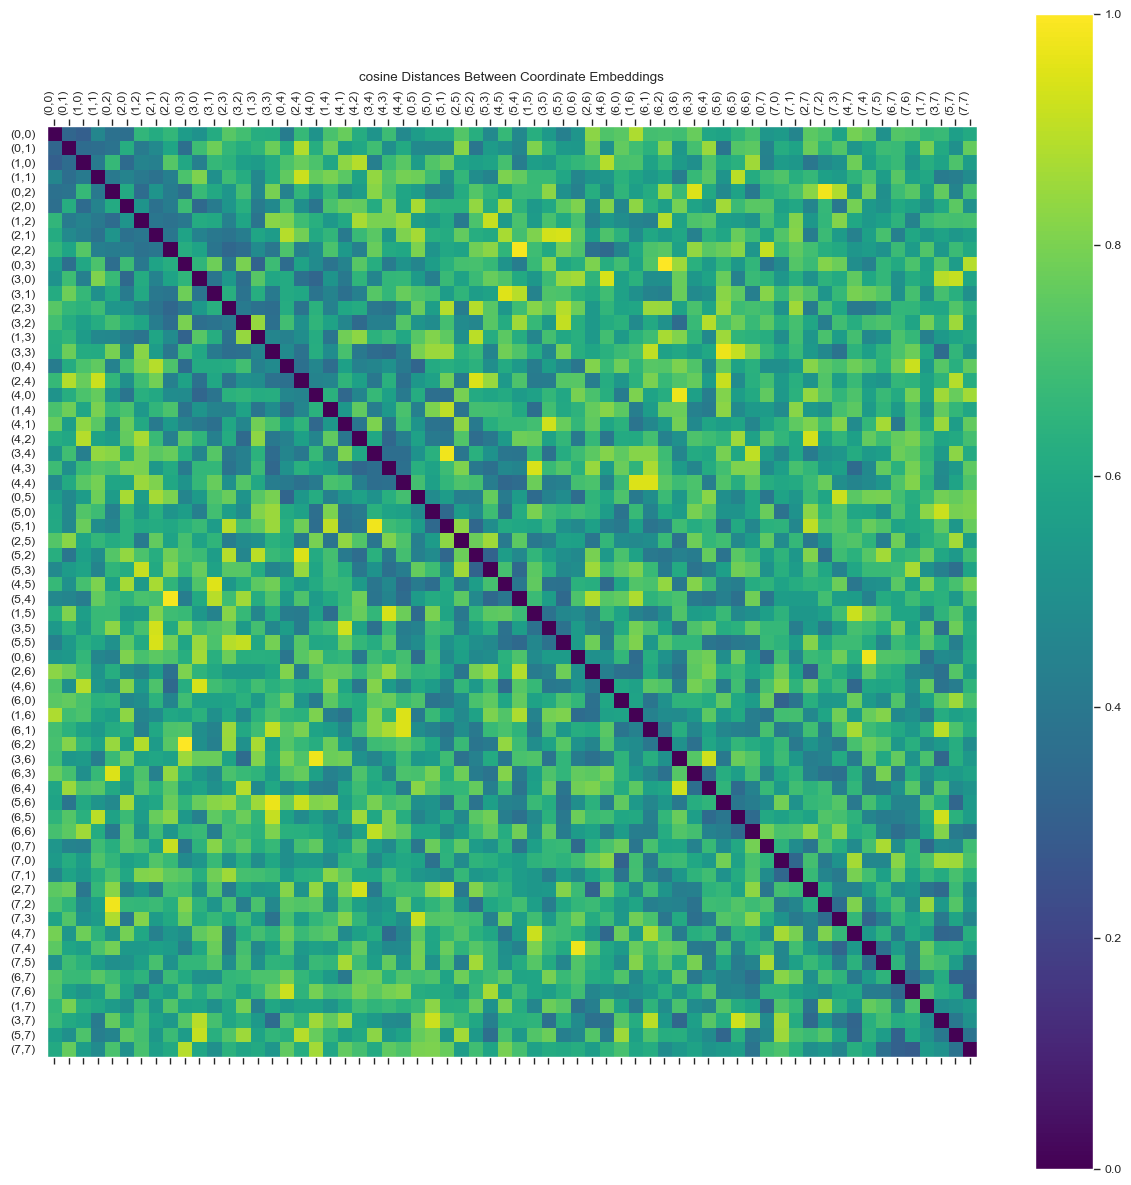

In [50]:
plot_distances_matrix(**distances_result, show=False)
plt.show()

In [54]:
distance_grid: Float[np.ndarray, "n n n n"] = compute_grid_distances(
    embedding_distances_matrix=distances_result["embedding_distances_matrix"],
    tokenizer=TOKENIZER,
)

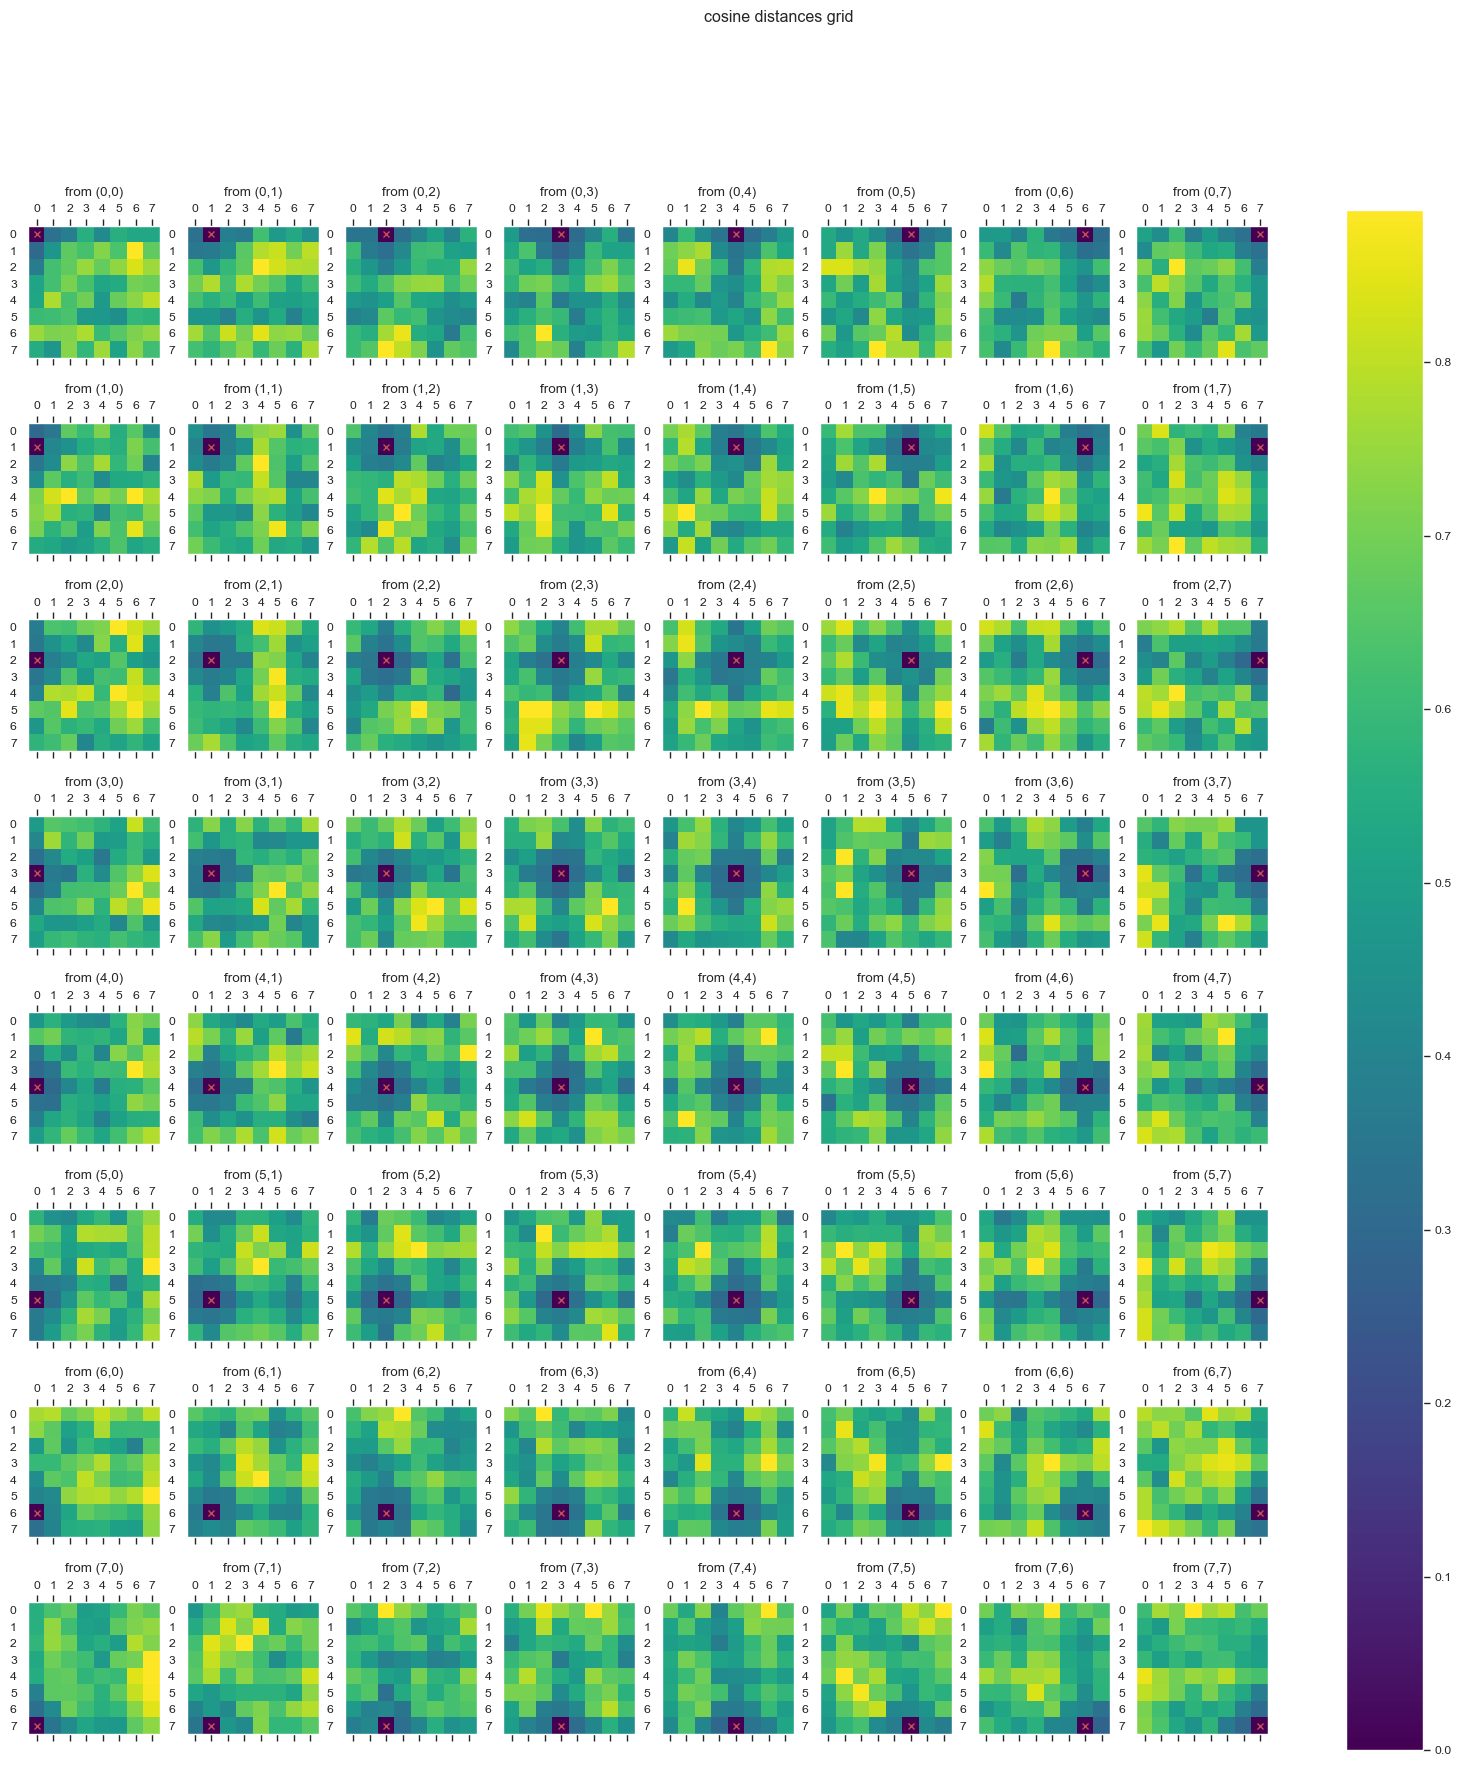

In [56]:
plot_distance_grid(distance_grid, embedding_metric=distances_result["embedding_metric"], show=False)
plt.show()


In [ ]:
def plot_distance_correlation(distance_grid):
    pass
    

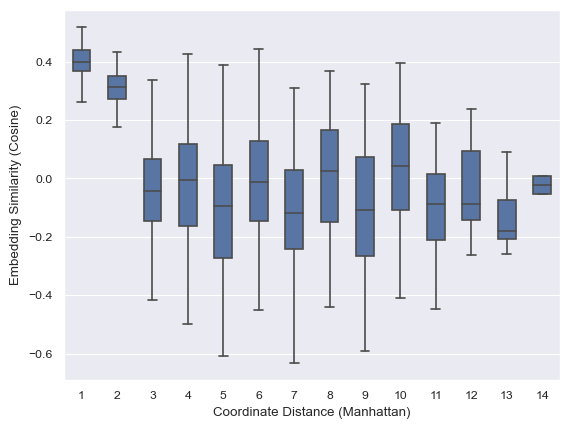

In [23]:


def euclidean_distance(a, b):
    # manhattan
    return np.sum(np.abs(np.array(a) - np.array(b)))

def get_euclidean_distances(coord_tuples):
    distances = []
    for i, coord1 in enumerate(coord_tuples):
        row_distances = []
        for j, coord2 in enumerate(coord_tuples):
            row_distances.append(euclidean_distance(coord1, coord2))
        distances.append(row_distances)
    return np.array(distances)

# Visualize cartesian distance vs cosine distance
sns.set_theme('paper')
def plot_cartesian_vs_cosine_distances(normed_w_e, vocab):
    coords_in_order = [eval(coord) for coord in vocab.keys()] # same order as rows in normed_w_e
    # embed_distances = cdist(normed_w_e, normed_w_e, p=1.0) # L2 of each row with normalization => cosine
    embed_distances = normed_w_e @ normed_w_e.T # cosine distance
    euclid_distances = get_euclidean_distances(coords_in_order)

    x = []
    y = []
    for row_idx in range(normed_w_e.shape[0]):
        source_coord = coords_in_order[row_idx]

        cosine_distances = embed_distances[row_idx].detach().cpu().numpy()
        euclidean_distances = euclid_distances[row_idx]

        # remove self
        cosine_distances = np.delete(cosine_distances, row_idx)
        euclidean_distances = np.delete(euclidean_distances, row_idx)

        x.extend(euclidean_distances.tolist())
        y.extend(cosine_distances.tolist())
    

    sns.boxplot(x=x, y=y, color=sns.color_palette()[0], showfliers=False, width=0.5)
    # sns.violinplot(x=x, y=y, color=sns.color_palette()[0])
    # plt.xticks(np.arange(1, euclid_distances.max()+1, 1)
    plt.xlabel('Coordinate Distance (Manhattan)')
    plt.ylabel('Embedding Similarity (Cosine)')
    # plt.savefig('results/geometry/cartesian_vs_cosine_distances.png', bbox_inches='tight', dpi=200)

# Split W_E to only include coords
filtered_vocab = {k: v for k, v in MODEL.tokenizer.vocab.items() if k not in [*MODEL.tokenizer.additional_special_tokens, MODEL.tokenizer.pad_token, MODEL.tokenizer.unk_token]}
filtered_w_e = MODEL.W_E[[v for k, v in filtered_vocab.items()]]
filtered_w_e /= filtered_w_e.norm(dim=1)[:, None]
plot_cartesian_vs_cosine_distances(filtered_w_e, filtered_vocab)